In [1]:
pip install pyet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error

In [3]:
# Ruta
RUTA = '/content/drive/MyDrive/Universidad/Evapotranspiration-Prediction-2022/data_processing/'
# Colores
colors = ['#D71BDD','#7C1BDD','#DD1B41','#46FF00','#61FF00','#80FF00','#9BFF00','#B9FF00','#F0FF00','#FFF000','#FFDC00','#FFC900','#FFBD00','#FFB200']

In [4]:
# Lectura de datos de previsión climática
csv_files = glob.glob(RUTA+'processed_forecast_data/*.csv')
csv_files.sort()
horizon_days = []
for i in csv_files:
  horizon_days.append(pd.read_csv(i))
for i in range(len(csv_files)):
  horizon_days[i].date = pd.to_datetime(horizon_days[i].date,format = '%Y-%m-%d')
  horizon_days[i] = horizon_days[i].set_index('date')

# Variables
# variables = ['tmin','tmax','temp','rh','ra','cod_wc','wind']
variables = ['tmin','tmax','temp','rh','ra','cod_wc','wind']
horizon_days_new = []
  
for i in range(len(horizon_days)):
  horizon_days[i]['temp'] = (horizon_days[i]['tmin']+horizon_days[i]['tmax'])/2
  horizon_days[i].rename(columns={'rhday':'rh'},inplace=True)
  horizon_days_new.append(horizon_days[i][variables])

dataset = pd.read_csv(RUTA+"data/PudahuelData-01012021-25062022.csv")
dataset_back = dataset.iloc[:516,:]
dataset_comp = dataset.iloc[516:,:]
dataset_back = dataset_back.set_index('date')
dataset_comp = dataset_comp.set_index('date')

In [7]:
# Días hacia atrás (máximo 516)
# n_days = 30
days_ = []
metrics = [[],[]]
factor = []
for n_days in range(15,516,15):
  # Días de forecast
  n_forecast = len(horizon_days_new[0])

  # Variables a utilizar

  df_X_comp = dataset_comp[variables]
  df_Y_comp = dataset_comp[["et0"]]

  df_X = dataset_back[variables]  
  df_Y = dataset_back[["et0"]]
  et0_pred = [[],[]]
  # Movimiento de 'n_days' en el tiempo
  for i in range (n_forecast):
    if i==0:
      df_X = df_X.iloc[-n_days+i:,:]
      df_Y = df_Y.iloc[-n_days+i:,:]
    # elif i<=n_forecast:
    else:
      df_X = df_X.iloc[-n_days+1:,:]
      df_Y = df_Y.iloc[-n_days+1:,:]
      sample_X = pd.DataFrame(data=df_X_comp.iloc[i-1,:].values.reshape(1,len(df_X.columns)),columns=df_X_comp.iloc[i-1,:].index)
      sample_X['date'] = df_X_comp.iloc[i-1,:].name
      sample_X = sample_X.set_index('date')
      df_X = pd.concat([df_X,sample_X])
      sample_Y = pd.DataFrame(data=df_Y_comp.iloc[i-1,:].values.reshape(1,len(df_Y.columns)),columns=df_Y_comp.iloc[i-1,:].index)
      sample_Y['date'] = df_Y_comp.iloc[i-1,:].name
      sample_Y = sample_Y.set_index('date')
      df_Y = pd.concat([df_Y,sample_Y])    
    # else: break
    horizon_ = horizon_days_new[0].iloc[i:,:]
    regression = LinearRegression()
    regression.fit(df_X,df_Y)
    y_pred_train = regression.predict(df_X)
    y_pred_test = regression.predict(horizon_)
    et0_pred[0].append(horizon_.index[0])
    et0_pred[1].append(y_pred_test[0][0])
    # print(pd.concat([df_X,df_Y],axis=1))
    # print('y_pred: ',y_pred_test[0][0],'DAY: ',horizon_.index[0].strftime(format='%Y-%m-%d'),'^^^^^^')

  et0_pred_1 = pd.DataFrame({'date':et0_pred[0],'et0':et0_pred[1]})
  et0_pred_1 = et0_pred_1.set_index('date')
  et0_pred_1 = et0_pred_1.iloc[:-1]
  date = []
  et0_real = []
  for i in range(len(et0_pred_1.index)):
    for j in range(len(df_Y_comp.index)):
      if (et0_pred_1.index[i].strftime(format='%Y-%m-%d')==df_Y_comp.index[j]):
        date.append(df_Y_comp.index[i])
        et0_real.append(df_Y_comp['et0'][i])
  et0_real_1 = pd.DataFrame({'date': date,'et0': et0_real})
  et0_real_1 = et0_real_1.set_index('date')

  et0_pred_pmfao56 = horizon_days[0]['et0_pmfao56_raxwc']
  et0_pred_pmfao56 = et0_pred_pmfao56.iloc[:-1]
  # cc = np.corrcoef(et0_real_1.values.reshape(1,len(et0_real_1)),et0_pred_pmfao56.values.reshape(1,len(et0_pred_1)))
  # CC = np.corrcoef(et0_real_1.values.reshape(1,len(et0_real_1)),et0_pred_1.values.reshape(1,len(et0_pred_1)))
  # r2 = r2_score(et0_real_1,et0_pred_1*0.75)
  # r2_pm = r2_score(et0_real_1,et0_pred_pmfao56)
  # plt.scatter(et0_real_1,et0_pred_1,color='g')
  # print('CC regresión lineal: ',CC[0][1])
  # print('CC et0 vs fórmula clásica: ',cc[0][1])
  # print(r2,r2_pm)
  # plt.xlim([0,plt.xlim()[1]])
  # plt.ylim([0,plt.ylim()[1]])
  # graph = plt.plot([-100, 100], [-100, 100])
  # Creando Rectas para graficar train y test
  regression_test = LinearRegression(fit_intercept=False)
  regression_test.fit(et0_pred_1,et0_real_1)
  regression_train = LinearRegression(fit_intercept=False)
  regression_train.fit(y_pred_train,df_Y)
  # --------------------------------------------------------------
  fig = plt.figure(figsize=(13,8))

  r_2 = r2_score(et0_real_1,et0_pred_1)
  CC = np.corrcoef(et0_real_1.values.reshape(1,len(et0_real_1)),et0_pred_1.values.reshape(1,len(et0_pred_1)))[0][1]
  metrics[0].append(r_2)
  metrics[1].append(CC)
  days_.append(n_days)
  factor.append(regression_test.coef_[0][0])
  # Grafico Rectas
  plt.plot(y_pred_train,regression_train.predict(y_pred_train),color='royalblue',linestyle='dotted', label = 'Linear (Train - Last model): y = '+str(regression_train.coef_[0][0])+"x"+" CC = "+str(np.corrcoef(df_Y.values.reshape(1,len(df_Y)),y_pred_train.reshape(1,len(y_pred_train)))[0][1])+"  R² = "+str(r2_score(df_Y,y_pred_train)))
  plt.plot(et0_pred_1,regression_test.predict(et0_pred_1),color='orange',linestyle='dotted',label = 'Linear (Test): y = '+str(regression_test.coef_[0][0])+"x"+" CC = "+str(np.corrcoef(et0_real_1.values.reshape(1,len(et0_real_1)),et0_pred_1.values.reshape(1,len(et0_pred_1)))[0][1])+"  R² = "+str(r2_score(et0_real_1,et0_pred_1)))

  # Puntos
  plt.scatter(y_pred_train,df_Y,color='royalblue',marker = 'D',label = 'Train')
  plt.scatter(et0_pred_1,et0_real_1,color='orange',marker='o',edgecolor='black',label = 'Test')
  # Fórmula
  # plt.title("Fórmula de aproximación: ET0 = "+str(regression.coef_[0][0])+"∙Tmin + "+str(regression.coef_[0][1])+"∙Tmax + "+str(regression.intercept_[0]))
  # Ejes
  plt.title(str(n_days)+' days back')
  plt.xlabel("ET0 Regresión")
  plt.ylabel("ET0 Referencia")
  leg = plt.legend()
  plt.grid()
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

([<matplotlib.axis.XTick at 0x7f3c9d2e4f50>,
 <a list of 34 Text major ticklabel objects>)

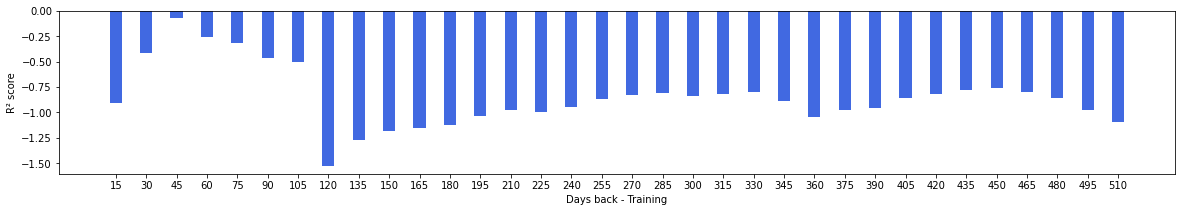

In [18]:
cond = 0 # R²:0 ; CC:1
figw = plt.figure(figsize=(20,3))
plt.xlabel("Days back - Training")
if cond==0:
  plt.ylabel("R² score")
else:
  plt.ylabel("CC score")
plt.bar(days_,metrics[cond],width=6,color='royalblue')
plt.xticks(days_)

In [86]:
metrics[days_.index(45)],metrics[days_.index(135)]

(0.557359182760779, 0.563877712448852)

In [19]:
n_days = 45
# Días de forecast
n_forecast = len(horizon_days_new[0])

# Variables a utilizar

df_X_comp = dataset_comp[variables]
df_Y_comp = dataset_comp[["et0"]]

df_X = dataset_back[variables]  
df_Y = dataset_back[["et0"]]
et0_pred = [[],[]]
models = [[],[]]
# Movimiento de 'n_days' en el tiempo
for i in range (n_forecast):
  if i==0:
    df_X = df_X.iloc[-n_days+i:,:]
    df_Y = df_Y.iloc[-n_days+i:,:]
  # elif i<=n_forecast:
  else:
    df_X = df_X.iloc[-n_days+1:,:]
    df_Y = df_Y.iloc[-n_days+1:,:]
    sample_X = pd.DataFrame(data=df_X_comp.iloc[i-1,:].values.reshape(1,len(df_X.columns)),columns=df_X_comp.iloc[i-1,:].index)
    sample_X['date'] = df_X_comp.iloc[i-1,:].name
    sample_X = sample_X.set_index('date')
    df_X = pd.concat([df_X,sample_X])
    sample_Y = pd.DataFrame(data=df_Y_comp.iloc[i-1,:].values.reshape(1,len(df_Y.columns)),columns=df_Y_comp.iloc[i-1,:].index)
    sample_Y['date'] = df_Y_comp.iloc[i-1,:].name
    sample_Y = sample_Y.set_index('date')
    df_Y = pd.concat([df_Y,sample_Y])    
  # else: break
  horizon_ = horizon_days_new[0].iloc[i:,:]
  regression = LinearRegression()
  regression.fit(df_X,df_Y)
  y_pred_train = regression.predict(df_X)
  f = factor[days_.index(n_days)]
  y_pred_test = regression.predict(horizon_)*f
  models[0].append(regression.coef_[0]) # Coeficientes del i modelo
  models[1].append(regression.intercept_[0]) # Intercepto del i modelo
  et0_pred[0].append(horizon_.index[0])
  et0_pred[1].append(y_pred_test[0][0])
  # print(pd.concat([df_X,df_Y],axis=1))
  # print('y_pred: ',y_pred_test[0][0],'DAY: ',horizon_.index[0].strftime(format='%Y-%m-%d'),'^^^^^^')

Fórmula de aproximación: ET0 =  -0.39110682950287323∙tmin + -0.2717988914566398∙tmax + 0.730841599319764∙temp + -0.027008478752484747∙rh + 0.0937584179148683∙ra + 0.021503020037985987∙cod_wc + 0.1196553388631672∙wind + -0.3009780630738086


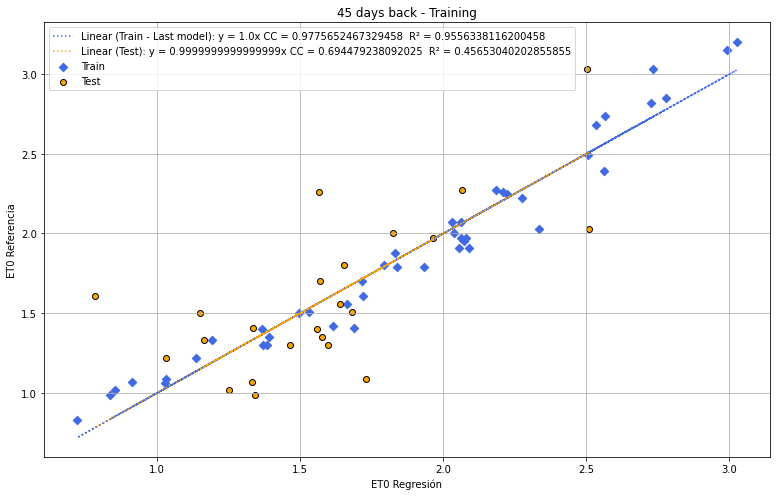

In [20]:
et0_pred_1 = pd.DataFrame({'date':et0_pred[0],'et0':et0_pred[1]})
et0_pred_1 = et0_pred_1.set_index('date')
et0_pred_1 = et0_pred_1.iloc[:-1]
et0_pred_1
date = []
et0_real = []
for i in range(len(et0_pred_1.index)):
  for j in range(len(df_Y_comp.index)):
    if (et0_pred_1.index[i].strftime(format='%Y-%m-%d')==df_Y_comp.index[j]):
      date.append(df_Y_comp.index[i])
      et0_real.append(df_Y_comp['et0'][i])
et0_real_1 = pd.DataFrame({'date': date,'et0': et0_real})
et0_real_1 = et0_real_1.set_index('date')

et0_pred_pmfao56 = horizon_days[0]['et0_pmfao56_raxwc']
et0_pred_pmfao56 = et0_pred_pmfao56.iloc[:-1]
# cc = np.corrcoef(et0_real_1.values.reshape(1,len(et0_real_1)),et0_pred_pmfao56.values.reshape(1,len(et0_pred_1)))
# CC = np.corrcoef(et0_real_1.values.reshape(1,len(et0_real_1)),et0_pred_1.values.reshape(1,len(et0_pred_1)))
# r2 = r2_score(et0_real_1,et0_pred_1*0.75)
# r2_pm = r2_score(et0_real_1,et0_pred_pmfao56)
# plt.scatter(et0_real_1,et0_pred_1,color='g')
# print('CC regresión lineal: ',CC[0][1])
# print('CC et0 vs fórmula clásica: ',cc[0][1])
# print(r2,r2_pm)
# plt.xlim([0,plt.xlim()[1]])
# plt.ylim([0,plt.ylim()[1]])
# graph = plt.plot([-100, 100], [-100, 100])
# Creando Rectas para graficar train y test
regression_test = LinearRegression(fit_intercept=False)
regression_test.fit(et0_pred_1,et0_real_1)
regression_train = LinearRegression(fit_intercept=False)
regression_train.fit(y_pred_train,df_Y)
# --------------------------------------------------------------
fig = plt.figure(figsize=(13,8))
# Grafico Rectas
plt.plot(y_pred_train,regression_train.predict(y_pred_train),color='royalblue',linestyle='dotted', label = 'Linear (Train - Last model): y = '+str(regression_train.coef_[0][0])+"x"+" CC = "+str(np.corrcoef(df_Y.values.reshape(1,len(df_Y)),y_pred_train.reshape(1,len(y_pred_train)))[0][1])+"  R² = "+str(r2_score(df_Y,y_pred_train)))
plt.plot(et0_pred_1,regression_test.predict(et0_pred_1),color='orange',linestyle='dotted',label = 'Linear (Test): y = '+str(regression_test.coef_[0][0])+"x"+" CC = "+str(np.corrcoef(et0_real_1.values.reshape(1,len(et0_real_1)),et0_pred_1.values.reshape(1,len(et0_pred_1)))[0][1])+"  R² = "+str(r2_score(et0_real_1,et0_pred_1)))

# Puntos
plt.scatter(y_pred_train,df_Y,color='royalblue',marker = 'D',label = 'Train')
plt.scatter(et0_pred_1,et0_real_1,color='orange',marker='o',edgecolor='black',label = 'Test')
# Fórmula
ecuacion = ''
for i in range(len(regression.coef_[0])+1):
  if i< len(regression.coef_[0]):
    ecuacion += str(regression.coef_[0][i])+'∙'+str(variables[i])+' + '
  else:
    ecuacion += str(regression.intercept_[0])

print("Fórmula de aproximación: ET0 = ",ecuacion)
# Ejes
plt.title(str(n_days)+' days back - Training')
plt.xlabel("ET0 Regresión")
plt.ylabel("ET0 Referencia")
leg = plt.legend()
plt.grid()
plt.show()